In [1]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join("data","images")
number_images = 30

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print("collecting image {}".format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname, frame)
    cv2.imshow("frame", frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

# 2. Review dataset and build image loading function #

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2022-08-14 09:40:21.533955: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


**Load image into TF Data Pipeline**

In [3]:
images = tf.data.Dataset.list_files("data/train/images/*.jpg", shuffle=False)

2022-08-14 07:55:50.375018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
images.as_numpy_iterator().next()

b'data/train/images/620acac6-faaf-11ec-8632-258024ba501b.jpg'

In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[227, 215, 193],
        [227, 215, 193],
        [227, 215, 193],
        ...,
        [213, 198, 177],
        [213, 198, 177],
        [213, 198, 177]],

       [[227, 215, 193],
        [227, 215, 193],
        [227, 215, 193],
        ...,
        [213, 198, 177],
        [213, 198, 177],
        [213, 198, 177]],

       [[227, 215, 193],
        [227, 215, 193],
        [227, 215, 193],
        ...,
        [213, 198, 177],
        [213, 198, 177],
        [213, 198, 177]],

       ...,

       [[196, 178, 156],
        [196, 178, 156],
        [194, 178, 155],
        ...,
        [157, 147, 158],
        [161, 149, 163],
        [150, 138, 152]],

       [[195, 179, 156],
        [195, 179, 156],
        [195, 178, 158],
        ...,
        [156, 146, 157],
        [155, 144, 158],
        [138, 127, 141]],

       [[195, 179, 156],
        [194, 178, 155],
        [194, 177, 157],
        ...,
        [155, 145, 156],
        [145, 134, 148],
        [125, 114, 128]]

**View raw images with matplotlib**

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

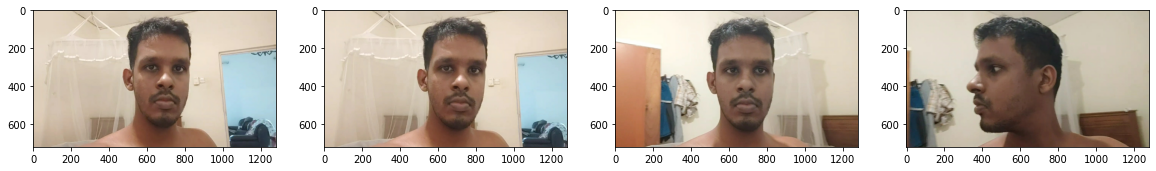

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3 Partition unaugmented Data #

# Apply image augmentations on images and labels using albumentations #

**Setup albumentaions transform pipeline**

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([
    alb.RandomCrop(width=1000, height=700),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
],bbox_params=alb.BboxParams(format="albumentations",
                            label_fields=["class_labels"]))

**Load test image and Annotation with opencv and json**

In [ ]:
img = cv2.imread(os.path.join("data","train","images","620acac7-faaf-11ec-8632-258024ba501b.jpg"))

In [ ]:
with open(os.path.join("data","train","labels","620acac7-faaf-11ec-8632-258024ba501b.json"),"r") as f:
    label = json.load(f)

In [ ]:
label["shapes"][0]["points"]

[[460.93442622950823, 23.65573770491803],
 [901.0983606557377, 626.1147540983607]]

**Extract cordinates and rescale to match image resolution**

In [ ]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [ ]:
coords = list(np.divide(coords, [1280,720,1280,720]))

In [ ]:
coords

[0.3601050204918033, 0.0328551912568306, 0.7039830942622951, 0.869603825136612]

**Apply augmentations and view results**

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=["face"])

In [ ]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

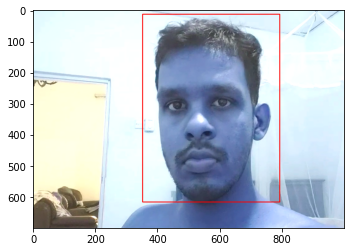

In [ ]:
cv2.rectangle(augmented["image"],
             tuple(np.multiply(augmented["bboxes"][0][:2],[1000,700]).astype(int)),
             tuple(np.multiply(augmented["bboxes"][0][2:],[1000,700]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented["image"])

# Build and run Augmentation pipeline #

**Run Augmentation pipeline**

In [ ]:
for partition in ["train","test","val"]:
    for image in os.listdir(os.path.join("data",partition,"images")):
        img = cv2.imread(os.path.join("data",partition,"images",image))
        
        coords = [0,0,0.000001,0.000001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)
            
            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            coords = list(np.divide(coords, [1280,720,1280,720]))
            
        try:
            for x in range(60):
                augmented = augmentor(image=img,bboxes=[coords],class_labels=["face"])
                cv2.imwrite(os.path.join("aug_data",partition,"images",f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation["image"] = image
                
                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0:
                        annotation["bbox"] = [0,0,0,0]
                        annotation["class"] = 0
                        
                    else:
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else:
                    annotation["bbox"] = [0,0,0,0]
                    annotation["class"] = 0
                    
                
                with open(os.path.join("aug_data",partition,"labels",f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
            
        except Exception as e:
            print(e)
                    

image must be numpy array type
Requested crop size (700, 1000) is larger than the image size (480, 640)
image must be numpy array type


**Load augmented images to tensorflow Dataset**

In [4]:
train_images = tf.data.Dataset.list_files("aug_data/train/images/*.jpg", shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

2022-08-14 08:24:53.749975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
test_images = tf.data.Dataset.list_files("aug_data/test/images/*.jpg", shuffle=False)
test_images = test_images.map(load_image)
tst_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files("aug_data/val/images/*.jpg", shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# 6 Prepare Labels #

**Build label loading function**

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label["class"]], label["bbox"]

**Load labels to tensorflow dataset**

In [8]:
train_labels = tf.data.Dataset.list_files("aug_data/train/labels/*json", shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [9]:
test_labels = tf.data.Dataset.list_files("aug_data/test/labels/*json", shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [10]:


val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))




In [11]:
train_labels.as_numpy_iterator().next()


(array([1], dtype=uint8),
 array([0.1532, 0.1162, 0.539 , 0.972 ], dtype=float16))

# Combine images and labels datasets #

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
# Helps to prevent bottlenecks when loading and training data
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [15]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.      , 0.      , 0.      , 0.      ],
        [0.2727  , 0.04605 , 0.7124  , 0.8706  ],
        [0.4326  , 0.1235  , 0.8525  , 1.      ],
        [0.1434  , 0.001663, 0.5903  , 0.9688  ],
        [0.4216  , 0.2089  , 0.7217  , 0.874   ],
        [0.375   , 0.01808 , 0.815   , 0.879   ],
        [0.3218  , 0.03317 , 0.73    , 1.      ],
        [0.4119  , 0.1598  , 0.799   , 0.9956  ]], dtype=float16))

In [16]:
data_samples = train.as_numpy_iterator()

In [17]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


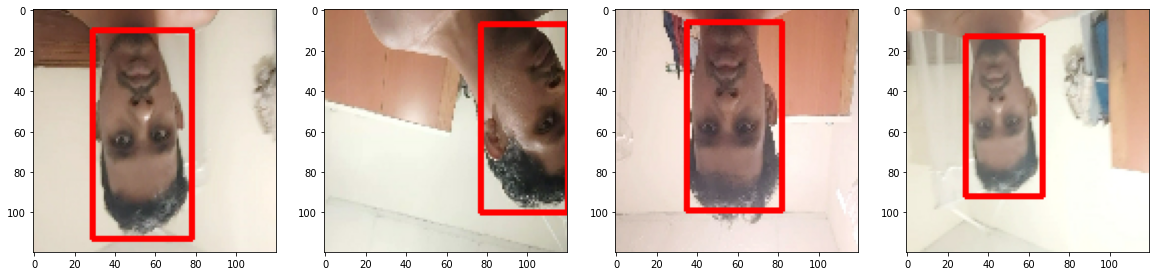

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                 (155,0,0),2)
    ax[idx].imshow(sample_image)

# Build deep learning using the functional API #

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [20]:
vgg = VGG16(include_top = False)

In [21]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Build instance of network**

In [22]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top = False)(input_layer)
    
    # Classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [23]:
facetracker = build_model()

In [24]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [25]:
X, y = train.as_numpy_iterator().next()

In [26]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2034 , 0.1243 , 0.555  , 0.8657 ],
        [0.4272 , 0.0459 , 0.8174 , 0.9146 ],
        [0.5317 , 0.2327 , 0.87   , 0.9893 ],
        [0.0699 , 0.0968 , 0.4255 , 0.846  ],
        [0.597  , 0.1344 , 0.9487 , 0.8755 ],
        [0.3264 , 0.03044, 0.7026 , 0.8584 ],
        [0.4878 , 0.     , 0.896  , 0.9683 ],
        [0.4766 , 0.     , 0.8706 , 0.871  ]], dtype=float16))

In [27]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 465ms/step


In [28]:
classes, coords

(array([[0.542543  ],
        [0.5372904 ],
        [0.55236435],
        [0.5703953 ],
        [0.5526064 ],
        [0.507762  ],
        [0.5601673 ],
        [0.56094086]], dtype=float32),
 array([[0.62430173, 0.6207346 , 0.6039958 , 0.65444994],
        [0.63398534, 0.6032885 , 0.55293643, 0.5882863 ],
        [0.6398804 , 0.6597336 , 0.5641587 , 0.61772203],
        [0.6520612 , 0.68613863, 0.57936454, 0.6661292 ],
        [0.63068557, 0.65469575, 0.6301472 , 0.57071424],
        [0.7020758 , 0.6711136 , 0.5850966 , 0.65586865],
        [0.65447044, 0.69158715, 0.5560087 , 0.63597584],
        [0.63318515, 0.6892047 , 0.6124841 , 0.66836697]], dtype=float32))

**Define optimizer and LR**

In [29]:
len(train)

795

In [30]:
batches_per_epoch = 480
lr_decay = (1./0.75 -1)/batches_per_epoch

In [31]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=lr_decay)

**Create localization loss and Classification loss**

In [32]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:, 3] - y_true[:,1]
    w_true = y_true[:, 2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    return delta_coord + delta_size    
    

In [33]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

**Test out metrics**

In [34]:
localization_loss(y[1], coords).numpy()

10.745607

In [35]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [36]:
model = FaceTracker(facetracker)

In [37]:
model.compile(opt, classloss, regressloss)

**Train**

In [38]:
logdir='logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:


hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])



Epoch 1/5


2022-08-14 08:25:31.312317: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}

	while inferring type of node 'binary_crossentropy/cond/output/_10'


795/795 [==============================] - 862s 1s/step - total_loss: 0.2512 - class_loss: 0.0540 - regress_loss: 0.2241 - val_total_loss: 0.0343 - val_class_loss: 3.4902e-04 - val_regress_loss: 0.0342
Epoch 2/5
795/795 [==============================] - 885s 1s/step - total_loss: 0.0345 - class_loss: 0.0083 - regress_loss: 0.0304 - val_total_loss: 0.0221 - val_class_loss: 1.9312e-05 - val_regress_loss: 0.0221
Epoch 3/5
795/795 [==============================] - 845s 1s/step - total_loss: 0.0122 - class_loss: 0.0018 - regress_loss: 0.0112 - val_total_loss: 0.0097 - val_class_loss: 1.6079e-05 - val_regress_loss: 0.0097
Epoch 4/5
795/795 [==============================] - 863s 1s/step - total_loss: 0.0047 - class_loss: 5.9146e-05 - regress_loss: 0.0047 - val_total_loss: 0.0055 - val_class_loss: 3.4960e-05 - val_regress_loss: 0.0055
Epoch 5/5
795/795 [==============================] - 823s 1s/step - total_loss: 0.0037 - class_loss: 3.0932e-05 - regress_loss: 0.0036 - val_total_loss: 0.012

# Make predictions #

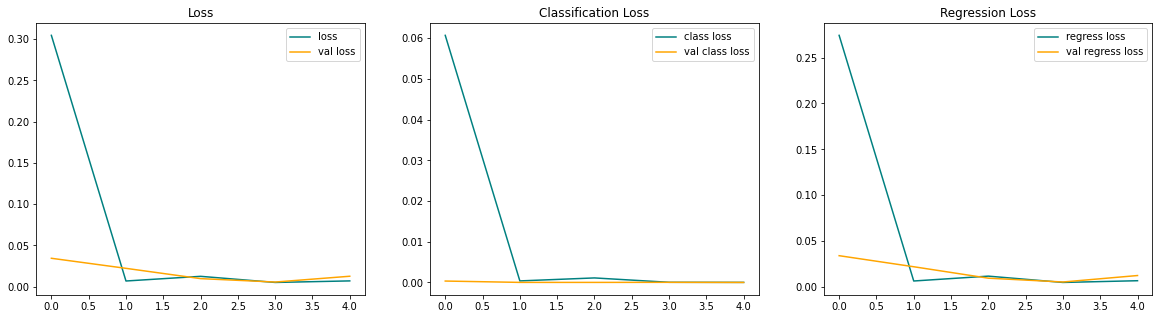

In [41]:


fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()



In [43]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [1000,700]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [1000,700]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)



In [70]:
yhat

[array([[0.9999991 ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [1.        ],
        [0.99999815],
        [1.        ]], dtype=float32),
 array([[0.3298315 , 0.16529621, 0.73954076, 0.8267437 ],
        [0.29196706, 0.12862918, 0.74088585, 0.9146412 ],
        [0.29121646, 0.13856128, 0.75630367, 0.9112095 ],
        [0.24000688, 0.10609403, 0.7834134 , 0.9553069 ],
        [0.2588742 , 0.11354436, 0.7525516 , 0.9230085 ],
        [0.2628526 , 0.10152046, 0.77653253, 0.9357341 ],
        [0.3131525 , 0.17797382, 0.70715797, 0.80741787],
        [0.2427382 , 0.12314484, 0.7299324 , 0.9196419 ]], dtype=float32)]

In [4]:
from tensorflow.keras.models import load_model

In [42]:
facetracker.save("facetracker.h5")

In [5]:
facetracker = load_model("facetracker.h5")

2022-08-14 09:40:38.362703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 68ms/step


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ff6a4f573a0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/weakref.py", line 345, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt

